This notebook attemps to solve the classification problem with housing data using the code templates developed for spark.
Version 1

In [1]:
%load_ext autoreload
%autoreload 2

#### Imports

###### Global Imports

In [2]:
import pandas as pd
import numpy as np
import sys
sys.path.append(r"D:\tigerml_new\code-templates\scripts\spark")

In [3]:
import warnings
warnings.filterwarnings('ignore')
from pyspark.sql import types as DT
from pyspark.sql import functions as F

from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics

from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler, StringIndexer, OneHotEncoderEstimator, Imputer
from pyspark.ml.evaluation import RegressionEvaluator

from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

import dp
import features
import model_gen
import model_eval
import utils
import eda

In [13]:
import warnings
warnings.filterwarnings('ignore')

import holoviews as hv
import hvplot

import panel as pn
pn.extension('bokeh')

#### DATA READ

In [5]:
%%time
data = dp.read_data(spark=spark, path="/FileStore/tables/titanic/train.csv", fs="dbfs", fmt="csv", header="true", inferschema="true")
data.printSchema()

root
 |-- PassengerId: integer (nullable = true)
 |-- Survived: integer (nullable = true)
 |-- Pclass: integer (nullable = true)
 |-- Name: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- Age: double (nullable = true)
 |-- SibSp: integer (nullable = true)
 |-- Parch: integer (nullable = true)
 |-- Ticket: string (nullable = true)
 |-- Fare: double (nullable = true)
 |-- Cabin: string (nullable = true)
 |-- Embarked: string (nullable = true)

Wall time: 17 s


#### Clean Columns in the data

In [6]:
data = dp._clean_columns(spark, data)

#### Columns Spec Summary

In [7]:
%%time
col_smry_1 = eda._column_values_summary(spark, data)
col_smry_1

Wall time: 23.1 s


passenger_id     survived       pclass        name  \
data type             IntegerType  IntegerType  IntegerType  StringType   
distinct count                891            2            3         891   
distinct count(perc)          100         0.22         0.34         100   

                             sex         age       sib_sp        parch  \
data type             StringType  DoubleType  IntegerType  IntegerType   
distinct count                 2          88            7            7   
distinct count(perc)        0.22        9.88         0.79         0.79   

                          ticket        fare       cabin    embarked  
data type             StringType  DoubleType  StringType  StringType  
distinct count               681         248         147           3  
distinct count(perc)       76.43       27.83        16.5        0.34

So we have around 4 columns which are numerical in type but in reality they are categorical "survived", "pclass", "sib_sp", "parch". They have to be converted to string/categorical

"survived" is the target variable. Thus that doesnt need casting

In [8]:
for col in ["pclass","sib_sp","parch"]:
    data = data.withColumn(col, F.col(col).cast(DT.StringType()))

#### Identification of columns types in the data

In [9]:
%%time
num_cols = dp._list_numerical_columns(spark, data)
cat_cols = dp._list_categorical_columns(spark, data)   
bool_cols = dp._list_boolean_columns(spark, data)
date_cols = dp._list_datelike_columns(spark, data)
num_cols, cat_cols, bool_cols, date_cols

Wall time: 1.92 ms


(['passenger_id', 'survived', 'age', 'fare'],
 ['pclass', 'name', 'sex', 'sib_sp', 'parch', 'ticket', 'cabin', 'embarked'],
 [],
 [])

#### Identification and Handling of Missing Values

In [10]:
print(data.count())
dp.identify_missing_values(spark, data).show()

891
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+
|passenger_id|survived|pclass|name|sex|age|sib_sp|parch|ticket|fare|cabin|embarked|
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+
|           0|       0|     0|   0|  0|177|     0|    0|     0|   0|  687|       2|
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+



For a start missing values can be handled as default imputation
 - age - mean
 - embarked - mode
 - cabin - mode

Other functionalities of missing values can be observed in dp module

# EDA

## Health Analysis

This tells about
1. percentage of Numeric variables and other variables
2. %age of missing values
3. %age of duplicated rows

In [11]:
health_plot=eda.plot_health(spark,data)

In [14]:
pn.panel(health_plot)

HoloViews(Layout)

### Missing Plot
This plot is the relation between no of non missing variables with no of missing observations

In [15]:
missing_value_plot=eda.missing_plot(spark,data)

In [16]:
pn.panel(missing_value_plot)

HoloViews(Bars)

### Missing data summary

In [17]:
missing_summary=eda.missing_value_summary(spark,data)

In [18]:
pn.panel(missing_summary)

DataFrame(DataFrame)

### Outliers summary

In [19]:
outliers_summary=eda.get_outliers_table(spark,data)

In [20]:
pn.panel(outliers_summary,width=600)

DataFrame(DataFrame, width=600)

## Feature Analysis

In [32]:
numerical_analysis,categorical_analysis=eda.feature_analysis_table(spark,data)

#### descriptive analysis of numerical columns

In [22]:
pn.panel(numerical_analysis,width=1500)

DataFrame(DataFrame, width=1500)

#### descriptive statics of categorical variables

In [23]:
pn.panel(categorical_analysis,width=600)

DataFrame(DataFrame, width=600)

### Distributions of numerical and categorical variables

In [24]:
numerical_dict,categorical_dict=eda.feature_density_plots(spark,data)

#### To Fix: To plot all the variables in grid

In [25]:
pn.panel(numerical_dict[num_cols[0]])

HoloViews(Layout)

In [26]:
pn.panel(categorical_dict[cat_cols[0]])

HoloViews(Layout)

## Feature Interations

### correlation table

In [37]:
table=eda.get_feature_interactions(spark,data,plot='table')

In [39]:
pn.panel(table, width=600)

DataFrame(DataFrame, width=600)

### correlation plot

In [40]:
correlation_plot=eda.get_feature_interactions(spark,data,plot='plot')

In [41]:
pn.panel(correlation_plot)

HoloViews(HeatMap)

## Key Drivers

### correlations with target variabls

In [42]:
target_var='survived'
correlation_table=eda.correlation_with_target(spark,data,target_var)

In [43]:
pn.panel(correlation_table)

HoloViews(Bars)

### Feature Importance based on Random Forests
#### ---to be fixed, some categorical value issue due to missing values

In [59]:
#plot=feature_importance(spark,data,target_var,True)

In [60]:
#pn.panel(plot)

In [11]:
%%time
imputed_data = dp.handle_missing_values(spark, data)

Wall time: 7.83 s


In [12]:
%%time
dp.identify_missing_values(spark, imputed_data).show()

+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+
|passenger_id|survived|pclass|name|sex|age|sib_sp|parch|ticket|fare|cabin|embarked|
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+
|           0|       0|     0|   0|  0|  0|     0|    0|     0|   0|  687|       0|
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+

Wall time: 1.91 s


Looks like "embarked" column has more NAs thatn actual values.
So "mode" might not be a better option here. Thus replacing NA with a constant of "NA" seems more feasible

In [13]:
%%time
imputed_data = dp.handle_missing_values(spark, imputed_data, cols=[], rules={"cabin":{"method":"constant","impute_val":"Missing"}})

Wall time: 1.94 s


In [14]:
%%time
dp.identify_missing_values(spark, imputed_data).show()

+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+
|passenger_id|survived|pclass|name|sex|age|sib_sp|parch|ticket|fare|cabin|embarked|
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+
|           0|       0|     0|   0|  0|  0|     0|    0|     0|   0|    0|       0|
+------------+--------+------+----+---+---+------+-----+------+----+-----+--------+

Wall time: 1.64 s


#### Outlier Identification and Handling

In [15]:
%%time
print(imputed_data.count())
outlier_handled_data = dp.handle_outliers(spark, imputed_data, cols=[], drop=True, cap=False, method='iqr', iqr_multiplier=1.5)
print(outlier_handled_data.count())

891
721
Wall time: 15.3 s


In the above function if drop=False and cap=True is input, instead of dropping the rows, the outliers will be capped to the relevant bounds.

More on this in features module

#### Encoding Categorical Features

As observed earlier ocean_proximity is the only categorical feature in this data.

In [16]:
cat_cols

['pclass', 'name', 'sex', 'sib_sp', 'parch', 'ticket', 'cabin', 'embarked']

"survived" is the target var
"name", "ticket", "cabin" has no relevance here

In [17]:
%%time 
# by default onehot encoding is used.
target_col = 'survived'
non_relevant_cat_cols = ["name", "ticket", "cabin"]
cols=[x for x in cat_cols if x!=target_col and x not in non_relevant_cat_cols]
print(cols)
encoded_data = features.encode_categorical_features(spark, outlier_handled_data, cols=cols)

['pclass', 'sex', 'sib_sp', 'parch', 'embarked']
pclass {'method': 'onehot'}
sex {'method': 'onehot'}
sib_sp {'method': 'onehot'}
parch {'method': 'onehot'}
embarked {'method': 'onehot'}
Wall time: 18 s


In [18]:
encoded_data.printSchema()

root
 |-- passenger_id: integer (nullable = true)
 |-- survived: integer (nullable = true)
 |-- pclass: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sib_sp: string (nullable = true)
 |-- parch: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- passenger_id_outlier: boolean (nullable = false)
 |-- survived_outlier: boolean (nullable = false)
 |-- age_outlier: boolean (nullable = false)
 |-- fare_outlier: boolean (nullable = false)
 |-- pclass_index: double (nullable = false)
 |-- onehot_encoded_pclass: vector (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- onehot_encoded_sex: vector (nullable = true)
 |-- sib_sp_index: double (nullable = false)
 |-- onehot_encoded_sib_sp: vector (nullable = true)
 |-- parch_index: double (nullable = false)
 |-- onehot_

#### Model DataPrep and Vector Generation

In [19]:
%%time
outlier_indicators = [x for x in encoded_data.columns if 'outlier' in x]
index_columns = [x for x in encoded_data.columns if 'index' in x]
num_cols_1 = dp._list_numerical_columns(spark, encoded_data)
cat_cols_1 = dp._list_categorical_columns(spark, encoded_data)   
bool_cols_1 = dp._list_boolean_columns(spark, encoded_data)
date_cols_1 = dp._list_datelike_columns(spark, encoded_data)
num_cols_1, cat_cols_1, bool_cols_1, date_cols_1, index_columns, outlier_indicators

Wall time: 5.18 ms


(['passenger_id',
  'survived',
  'age',
  'fare',
  'pclass_index',
  'onehot_encoded_pclass',
  'sex_index',
  'onehot_encoded_sex',
  'sib_sp_index',
  'onehot_encoded_sib_sp',
  'parch_index',
  'onehot_encoded_parch',
  'embarked_index',
  'onehot_encoded_embarked'],
 ['pclass', 'name', 'sex', 'sib_sp', 'parch', 'ticket', 'cabin', 'embarked'],
 ['passenger_id_outlier', 'survived_outlier', 'age_outlier', 'fare_outlier'],
 [],
 ['pclass_index',
  'sex_index',
  'sib_sp_index',
  'parch_index',
  'embarked_index'],
 ['passenger_id_outlier', 'survived_outlier', 'age_outlier', 'fare_outlier'])

In [20]:
feature_cols = encoded_data.columns
feature_cols.remove(target_col)
non_relevant_num_cols=["passenger_id"]
feature_cols = [x for x in feature_cols if x not in index_columns]
feature_cols = [x for x in feature_cols if x not in outlier_indicators]
feature_cols = [x for x in feature_cols if x not in cat_cols_1]
feature_cols = [x for x in feature_cols if x not in date_cols_1]
feature_cols = [x for x in feature_cols if x not in non_relevant_num_cols]
feature_cols = [x for x in feature_cols if x not in non_relevant_cat_cols]
feature_cols

['age',
 'fare',
 'onehot_encoded_pclass',
 'onehot_encoded_sex',
 'onehot_encoded_sib_sp',
 'onehot_encoded_parch',
 'onehot_encoded_embarked']

In [21]:
%%time
model_data = dp.generate_features_vector(spark, encoded_data, feature_cols, output_col="features")

Wall time: 63.7 ms


#### Train Test Split

In [22]:
%%time
train_df, test_df = dp.test_train_split(spark, data=model_data, features_col="features", target_col=target_col, train_prop=0.7, random_seed=111)

Wall time: 45.4 ms


#### Model Train and Eval

In [23]:
model_gen.valid_model_types

['regression', 'classification']

In [24]:
model_gen.model_objects

{'regression': {'aft_survival': {'estimator': 'pyspark.ml.regression.AFTSurvivalRegression',
   'model': 'pyspark.ml.regression.AFTSurvivalRegressionModel'},
  'decision_tree': {'estimator': 'pyspark.ml.regression.DecisionTreeRegressor',
   'model': 'pyspark.ml.regression.DecisionTreeRegressionModel'},
  'gbt': {'estimator': 'pyspark.ml.regression.GBTRegressor',
   'model': 'pyspark.ml.regression.GBTRegressorModel'},
  'glm': {'estimator': 'pyspark.ml.regression.GeneralizedLinearRegression',
   'model': 'pyspark.ml.regression.GeneralizedLinearRegressionModel'},
  'isotonic_regression': {'estimator': 'pyspark.ml.regression.IsotonicRegression',
   'model': 'pyspark.ml.regression.IsotonicRegressionModel'},
  'linear_regression': {'estimator': 'pyspark.ml.regression.LinearRegression',
   'model': 'pyspark.ml.regression.LinearRegressionModel'},
  'rf': {'estimator': 'pyspark.ml.regression.RandomForestRegressor',
   'model': 'pyspark.ml.regression.RandomForestRegressorModel'}},
 'classificat

In [25]:
%%time
_model_str_ = 'logistic'
estimator = utils.load_class(model_gen.model_objects['classification'][_model_str_]['estimator'])
estimator

Wall time: 0 ns


pyspark.ml.classification.LogisticRegression

In [26]:
%%time
_model_ = estimator(featuresCol="features", labelCol="y", predictionCol='yhat')
model = _model_.fit(train_df)
preds = model.transform(test_df)
preds.select("y","yhat","probability","rawPrediction").show(5)

+---+----+--------------------+--------------------+
|  y|yhat|         probability|       rawPrediction|
+---+----+--------------------+--------------------+
|  0| 0.0|[0.54920540399073...|[0.19746071905878...|
|  0| 0.0|[0.86510985149387...|[1.85839576239186...|
|  0| 0.0|[0.97995934009648...|[3.88974787611495...|
|  0| 1.0|[0.28877652254032...|[-0.9013335841348...|
|  0| 1.0|[0.45181869207544...|[-0.1933251104711...|
+---+----+--------------------+--------------------+
only showing top 5 rows

Wall time: 2min 9s


In [27]:
preds.printSchema()

root
 |-- passenger_id: integer (nullable = true)
 |-- y: integer (nullable = true)
 |-- pclass: string (nullable = true)
 |-- name: string (nullable = true)
 |-- sex: string (nullable = true)
 |-- age: double (nullable = true)
 |-- sib_sp: string (nullable = true)
 |-- parch: string (nullable = true)
 |-- ticket: string (nullable = true)
 |-- fare: double (nullable = true)
 |-- cabin: string (nullable = true)
 |-- embarked: string (nullable = true)
 |-- passenger_id_outlier: boolean (nullable = false)
 |-- survived_outlier: boolean (nullable = false)
 |-- age_outlier: boolean (nullable = false)
 |-- fare_outlier: boolean (nullable = false)
 |-- pclass_index: double (nullable = false)
 |-- onehot_encoded_pclass: vector (nullable = true)
 |-- sex_index: double (nullable = false)
 |-- onehot_encoded_sex: vector (nullable = true)
 |-- sib_sp_index: double (nullable = false)
 |-- onehot_encoded_sib_sp: vector (nullable = true)
 |-- parch_index: double (nullable = false)
 |-- onehot_encoded

#### Model Evaluation Metrics

In [28]:
%%time
bin_cls_metrics = model_eval.get_binary_classification_metrics(spark, data=preds, y_col='y' , y_pred_cols=['yhat'], probability_cols=['probability'], threshold=0.5)
bin_cls_metrics.show()

+---------+----+
|   metric|yhat|
+---------+----+
| Accuracy| 0.8|
| F1 Score| 0.7|
|      TPR| 0.7|
|      FPR|0.15|
|Precision| 0.7|
|   Recall| 0.7|
|    AuROC|0.84|
|     AuPR| 0.7|
+---------+----+

Wall time: 21.4 s


#### Classification Plots

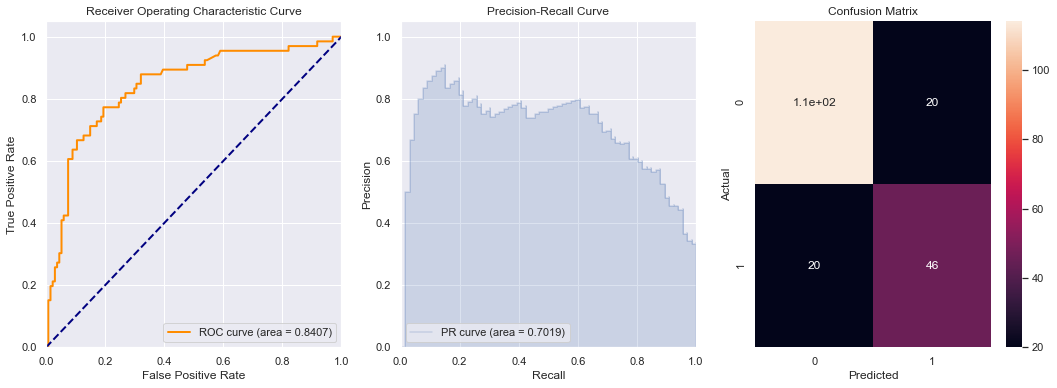

Wall time: 27.4 s


In [29]:
%%time
model_eval.get_binary_classification_plots(spark, data=preds, y_col='y' , y_pred_col='yhat', probability_col='probability', threshold=0.5)

In [30]:
feature_cols

['age',
 'fare',
 'onehot_encoded_pclass',
 'onehot_encoded_sex',
 'onehot_encoded_sib_sp',
 'onehot_encoded_parch',
 'onehot_encoded_embarked']

Other Additional Plots on Features vs the category of confusion matrix the data point belongs to can be obtained as follows

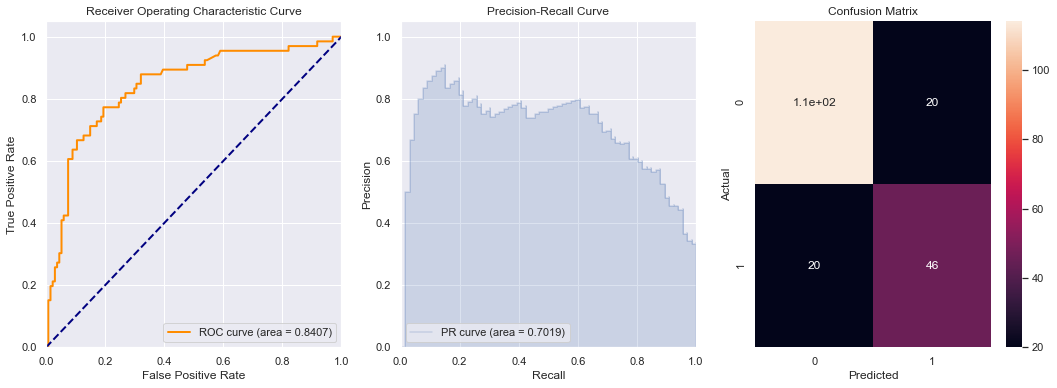

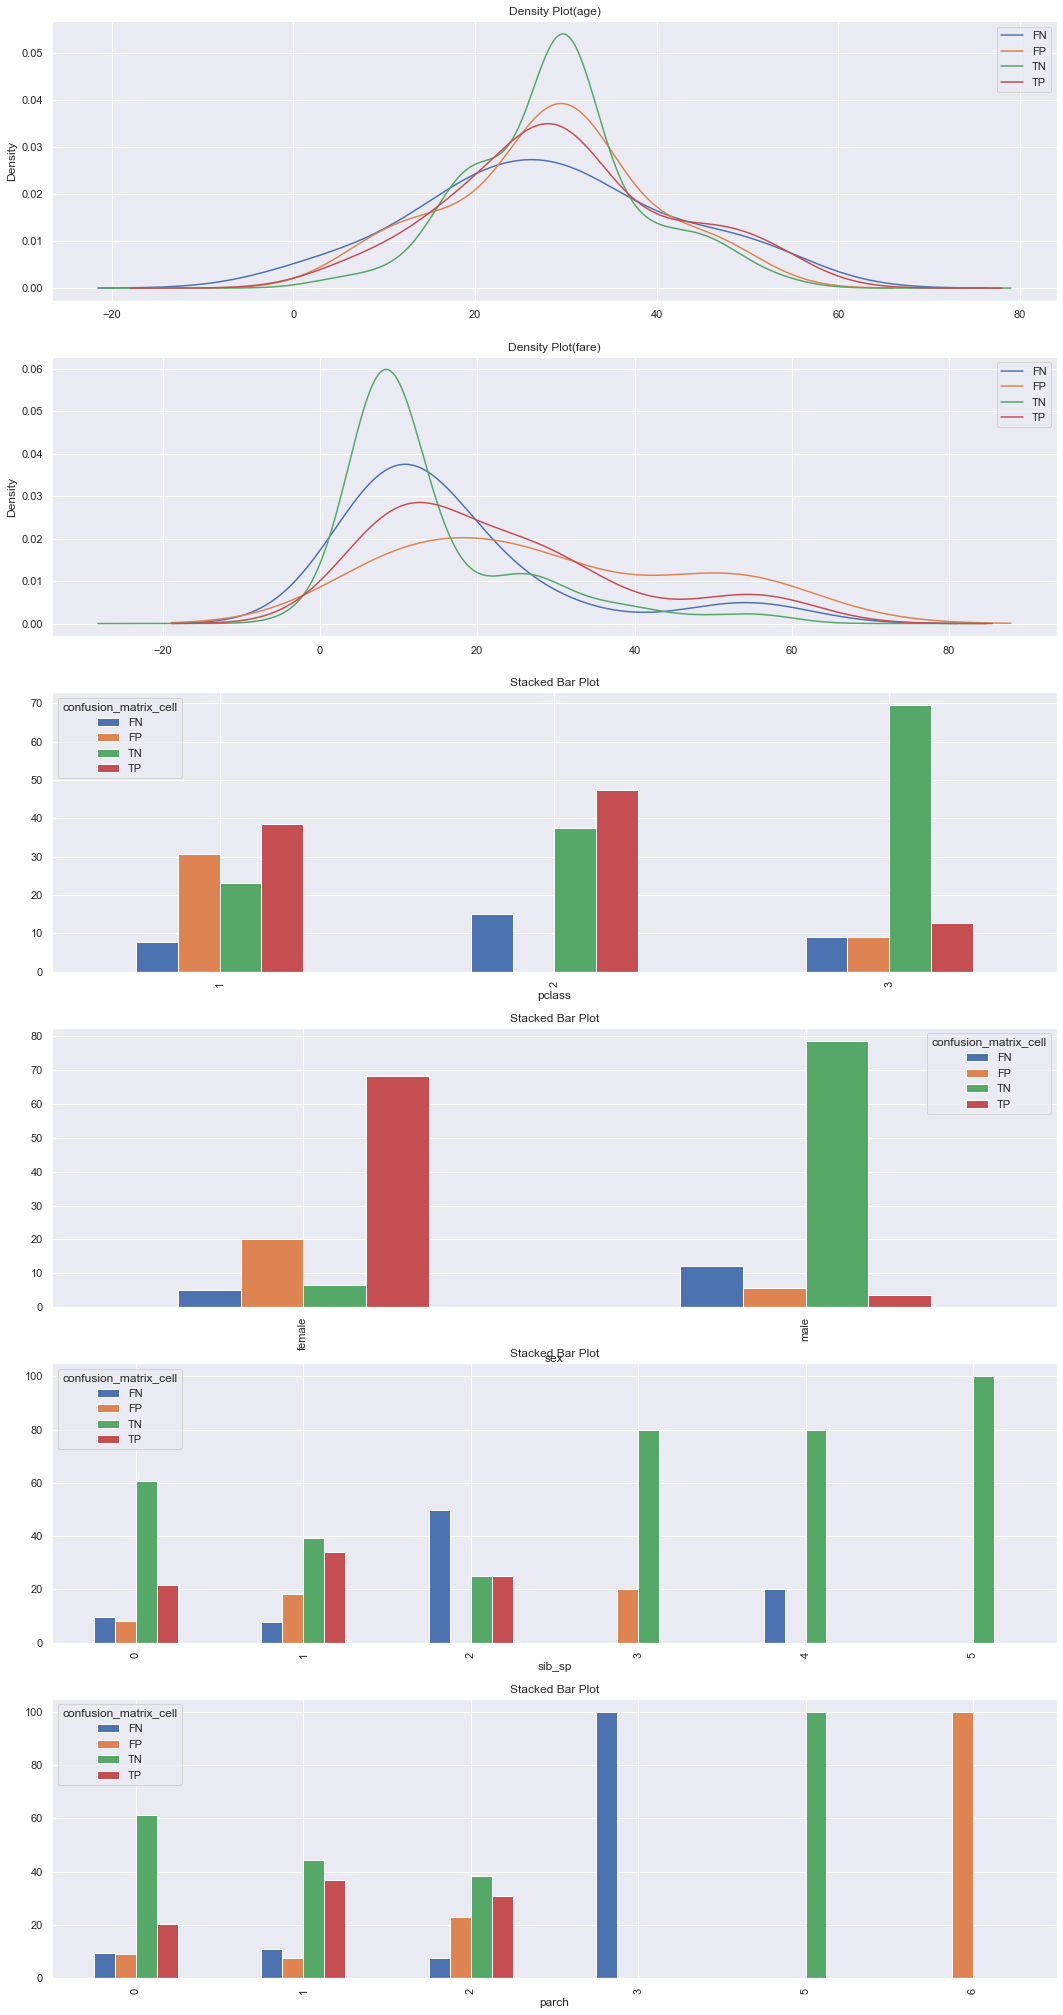

Wall time: 51.7 s


In [31]:
%%time
a = model_eval.get_binary_classification_plots(spark, data=preds, y_col='y' , y_pred_col='yhat', probability_col='probability', threshold=0.5,
                                               feature_cols=['age','fare','pclass','sex','sib_sp','parch'], feature_plots=True)